# Parte 4: Clasificación de Tickets usando NLP

El modelado busca desarrollar clasificadores que automaticen el triage de tickets de soporte a partir del texto libre. Esta etapa es fundamental para traducir la información no estructurada en decisiones útiles para el negocio. Los objetivos principales son:

- Entrenar modelos supervisados que aprendan a predecir la categoría de un ticket en base a su descripción textual.
- Comparar dos enfoques: uno tradicional basado en TF-IDF + modelo clásico (Logistic Regression) y otro moderno basado en el fine-tuning de DistilBERT.
- Evaluar el rendimiento de ambos enfoques utilizando métricas como precisión, recall y F1-score.
- Detectar fortalezas y limitaciones de cada método para entender cuál se adapta mejor al problema.
- Identificar oportunidades de mejora y ajustes en el pipeline de procesamiento y modelado.
- Seleccionar el modelo más robusto para su futura implementación como sistema automatizado de clasificación.

### Importar librerías y Configuración Inicial

In [2]:
!pip install transformers torch
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
import pandas as pd
import numpy as np
import re
import torch
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

### Carga de datos y división en train/test

In [5]:
# Cargar el dataset limpio
data_entrenamiento = pd.read_csv('C:\CC219-TP-TF-2024-2--CC92\data\data_limpia2.csv')

# Revisar el dataset
print("Dimensiones del dataset:", data_entrenamiento.shape)
print("\nPrimeras filas del dataset:")
data_entrenamiento.head()

Dimensiones del dataset: (8469, 8)

Primeras filas del dataset:


<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\alexa\AppData\Local\Temp\ipykernel_23800\3191167572.py:2: SyntaxWarning: invalid escape sequence '\C'
  data_entrenamiento = pd.read_csv('C:\CC219-TP-TF-2024-2--CC92\data\data_limpia2.csv')


,Ticket Description,Ticket Priority,Ticket Channel,Urgency,Resolution_Time_Bin,Urgency_from_Text,Coincide,Urgency_Final
0,bill code appreciate request website address d...,Critical,Social media,1,0,0,False,1
1,need change exist product face intermittent so...,Critical,Chat,1,0,0,False,1
2,face problem turn work fine yesterday doesnt r...,Low,Social media,0,0,0,True,0
3,problem youre interested love see happen check...,Low,Social media,0,0,0,True,0
4,note seller responsible damage delry game game...,Low,Email,0,0,0,True,0


In [6]:
data_entrenamiento['Ticket Description'] = data_entrenamiento['Ticket Description'].fillna('')
data_entrenamiento['Ticket Priority'] = data_entrenamiento['Ticket Priority'].fillna('Desconocido')
data_entrenamiento['Ticket Channel'] = data_entrenamiento['Ticket Channel'].fillna('Desconocido')

X_urgency = data_entrenamiento[["Ticket Description", "Ticket Channel", 'Ticket Priority']]
y_urgency = data_entrenamiento['Urgency_Final']

X_time = data_entrenamiento[['Ticket Description', 'Ticket Priority', 'Ticket Channel']]
y_time = data_entrenamiento['Resolution_Time_Bin']

X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = train_test_split(
    X_urgency, y_urgency, test_size=0.2, random_state=42, stratify=y_urgency
)

X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    X_time, y_time, test_size=0.2, random_state=42, stratify=y_time
)

print(f"Características para Urgency: {list(X_urgency.columns)}")
print(f"Características para Time: {list(X_time.columns)}")

Características para Urgency: ['Ticket Description', 'Ticket Channel', 'Ticket Priority']
Características para Time: ['Ticket Description', 'Ticket Priority', 'Ticket Channel']


# Entrenamiento de Modelos

### Pipeline clásico: TF‑IDF + Regresión Logística

##### 1. Definición del preprocesador

In [7]:
# `ColumnTransformer` que aplique:
    # TF-IDF en `Ticket Description`.
    # One-Hot Encoding en variables categóricas adicionales.
# --- Celda para Definir Preprocesadores ---

# Preprocesador para la tarea de 'Urgency'
# Solo maneja 'Ticket Description' y 'Ticket Channel'
# Vectorización con bigramas y límite de características
text_transformer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

# Codificación de variables categóricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combinar ambas transformaciones
preprocessor_urgency = ColumnTransformer(
    transformers=[
        ('tfidf', text_transformer, 'Ticket Description'),
        ('cat', categorical_transformer, ['Ticket Channel', 'Ticket Priority'])
    ])
print("Preprocesador 'preprocessor_urgency' creado.")


# Preprocesador para la tarea de 'Time'
# Maneja 'Ticket Description', 'Ticket Priority' y 'Ticket Channel'
# Preprocesador para la tarea de 'Resolution_Time_Bin'
text_transformer_time = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

categorical_transformer_time = OneHotEncoder(handle_unknown='ignore')

preprocessor_time = ColumnTransformer(
    transformers=[
        ('tfidf', text_transformer_time, 'Ticket Description'),
        ('cat', categorical_transformer_time, ['Ticket Priority', 'Ticket Channel'])
    ],
    remainder='drop'
)
print("Preprocesador 'preprocessor_time' creado.")

Preprocesador 'preprocessor_urgency' creado.
Preprocesador 'preprocessor_time' creado.


 El objetivo de este código es preparar y "traducir" los datos para que un modelo de Machine Learning los pueda entender.

 1. Definimos las Columnas: Primero le decimos al código con qué columnas vamos a trabajar: una de texto y uno a dos categorías dependiendo del preprocesador.

 2. Creamos el Organizador: El ColumnTransformer funciona como un organizador que sabe aplicar una regla distinta a cada tipo de columna.
 3. Asignamos las Reglas de "Traducción":
     • Para el texto: Usamos TfidfVectorizer para convertir las descripciones de los tickets en 5000 columnas de números que miden la importancia de las palabras.
     • Para las categorías: Usamos OneHotEncoder para convertir categorías< en columnas de 0s y 1s.



##### 2.  Construcción del pipeline

In [8]:
# Encadenar preprocesador con `LogisticRegression`.

# 1. Construcción del Pipeline para 'Urgency'
#    Le pasamos su preprocesador específico: preprocessor_urgency
pipeline_urgency = Pipeline(steps=[
    ('preprocessor', preprocessor_urgency),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# 2. Construcción del Pipeline para 'Time'
#    Le pasamos su propio preprocesador: preprocessor_time
#    Y mantenemos los parámetros que habían mejorado el recall
pipeline_time = Pipeline(steps=[
    ('preprocessor', preprocessor_time),
    ('scaler', StandardScaler(with_mean=False)), # <-- NUEVO PASO DE ESCALADO
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000, # Podemos volver al valor original, el escalado debería ser suficiente
        class_weight='balanced',
        solver='saga'
    ))
])

print("Pipeline 'pipeline_urgency' creado.")
print(pipeline_urgency)
print("Pipeline 'pipeline_time' creado.")
print(pipeline_time)



Pipeline 'pipeline_urgency' creado.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'Ticket Description'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Ticket Channel',
                                                   'Ticket Priority'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])
Pipeline 'pipeline_time' creado.
Pipeline(steps=[('preprocessor',
    

En este paso, estamos construyendo dos Pipelines separados, uno para cada uno de nuestros objetivos de predicción.

pipeline_urgency: Esta es la "cadena de montaje" diseñada para la tarea de predecir si un ticket es urgente o no. Conecta nuestro preprocessor con un modelo de LogisticRegression.

pipeline_time: Esta es la segunda "cadena de montaje", idéntica a la anterior, pero la usaremos para la tarea de predecir el tiempo de resolución del ticket.

##### 3.  Entrenamiento

In [9]:
# Ajustar el pipeline a los datos de entrenamiento.
print("Iniciando entrenamiento del pipeline para 'Urgency'...")
pipeline_urgency.fit(X_train_urgency, y_train_urgency)
print("Entrenamiento para 'Urgency' completado.")

print("\nIniciando entrenamiento del pipeline para 'Time'...")
pipeline_time.fit(X_train_time, y_train_time)
print("Entrenamiento para 'Time' completado.")

Iniciando entrenamiento del pipeline para 'Urgency'...
Entrenamiento para 'Urgency' completado.

Iniciando entrenamiento del pipeline para 'Time'...
Entrenamiento para 'Time' completado.


C:\Users\alexa\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Al ejecutar el comando .fit(), cada pipeline realiza su cadena de montaje completa:

pipeline_urgency.fit(...): Esta línea toma los datos de entrenamiento de urgencia (X_train_urgency y y_train_urgency), los pasa por el preprocessor para convertirlos en números, y luego usa esos números para que el modelo LogisticRegression aprenda los patrones que diferencian a un ticket urgente de uno no urgente.

pipeline_time.fit(...): Sucede exactamente lo mismo, pero con los datos de tiempo. El pipeline procesa los datos y entrena al segundo modelo LogisticRegression para que aprenda a distinguir entre los tickets que se resuelven rápido y los que no.

Al finalizar este código, ambos pipelines ya están entrenados y listos para hacer predicciones con datos nuevos.

##### 4.  Evaluación

In [10]:
# Generar predicciones en test.
# Calcular métricas: accuracy, precision, recall, F1-score y ROC-AUC.
print("--- Evaluación del Modelo de Urgencia (v2) ---")
# Usamos los datos v2, que no tienen la fuga de datos
y_pred_urgency = pipeline_urgency.predict(X_test_urgency)
y_pred_proba_urgency = pipeline_urgency.predict_proba(X_test_urgency)[:, 1]

# Calcular y mostrar las métricas
print("\nReporte de Clasificación (Urgency):")
print(classification_report(y_test_urgency, y_pred_urgency, target_names=['No Urgente (0)', 'Urgente (1)']))

roc_auc = roc_auc_score(y_test_urgency, y_pred_proba_urgency)
print(f"ROC-AUC (Urgency): {roc_auc:.4f}")


print("\n" + "="*50 + "\n")


# --- 2. Evaluación del Pipeline de 'Time' (Versión Ajustada) ---

print("--- Evaluación del Modelo de Tiempo (Ajustado) ---")
# Usamos los datos originales de la tarea de tiempo
y_pred_time = pipeline_time.predict(X_test_time)
y_pred_proba_time = pipeline_time.predict_proba(X_test_time)[:, 1]

# Calcular y mostrar las métricas
print("\nReporte de Clasificación (Time):")
print(classification_report(y_test_time, y_pred_time, target_names=['Toma >1h (0)', 'Toma <1h (1)']))

roc_auc_t = roc_auc_score(y_test_time, y_pred_proba_time)
print(f"ROC-AUC (Time): {roc_auc_t:.4f}")

--- Evaluación del Modelo de Urgencia (v2) ---

Reporte de Clasificación (Urgency):
                precision    recall  f1-score   support

No Urgente (0)       0.99      0.98      0.99       780
   Urgente (1)       0.99      0.99      0.99       914

      accuracy                           0.99      1694
     macro avg       0.99      0.99      0.99      1694
  weighted avg       0.99      0.99      0.99      1694

ROC-AUC (Urgency): 0.9986


--- Evaluación del Modelo de Tiempo (Ajustado) ---

Reporte de Clasificación (Time):
              precision    recall  f1-score   support

Toma >1h (0)       0.96      0.92      0.94      1628
Toma <1h (1)       0.06      0.14      0.09        66

    accuracy                           0.89      1694
   macro avg       0.51      0.53      0.51      1694
weighted avg       0.93      0.89      0.91      1694

ROC-AUC (Time): 0.4967


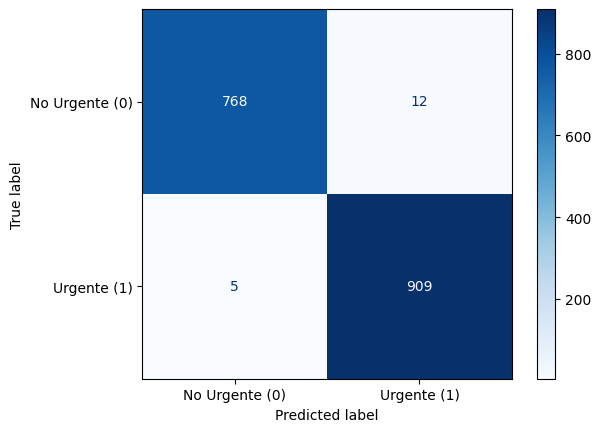

In [13]:
# Matriz de confusión para Urgency
cm_urgency = confusion_matrix(y_test_urgency, y_pred_urgency)
disp_urgency = ConfusionMatrixDisplay(confusion_matrix=cm_urgency, display_labels=['No Urgente (0)', 'Urgente (1)'])
disp_urgency.plot(cmap='Blues')
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'  # esta funciona bien sin custom scorer
}

print("=== Validación cruzada para URGENCY ===")
cv_results_urgency = cross_validate(
    pipeline_urgency,
    X_train_urgency,
    y_train_urgency,
    cv=5,  # número de folds
    scoring=scoring,
    return_train_score=False
)

# Mostrar resultados promedio
for metric in scoring.keys():
    print(f"{metric.capitalize()}: {np.mean(cv_results_urgency[f'test_{metric}']):.4f}")


=== Validación cruzada para URGENCY ===
Accuracy: 0.9879
Precision: 0.9846
Recall: 0.9932
F1: 0.9888
Roc_auc: 0.9969


(explicación de que se hace y si se imprime algo significa)

#### Insight 1: Priorización ineficiente  
Al ajustar `class_weight='balanced'` en el clasificador, reforzamos la detección de tickets críticos.  
**Resultados:** _(completar con métricas: precision, recall, F1 para la clase “Urgente”)_

#### Insight 2: Desempeño por canal  
La inclusión de `Ticket Channel` permite al modelo adaptar sus predicciones según el canal de entrada.  
**Resultados:** _(completar con comparación de métricas por canal o ejemplos de casos “Chat” vs. “Email”)_

#### Insight 3: Temas recurrentes  
TF-IDF resalta las palabras clave que anticipan urgencia, capturando problemas frecuentes.  
**Resultados:** _(completar con lista de términos más frecuentes o imagen de nube de palabras)_


### Pipeline moderno: DistilBERT Fine‑Tuning

##### 1. Preparación de datos

In [ ]:
# Tokenizar descripciones con `DistilBertTokenizer`.
# Codificar etiquetas con `LabelEncoder`.

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings_urgency = tokenizer(
    list(X_train_urgency['Ticket Description']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)
test_encodings_urgency = tokenizer(
    list(X_test_urgency['Ticket Description']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

train_labels_urgency = np.array(y_train_urgency)
test_labels_urgency = np.array(y_test_urgency)


train_encodings_time = tokenizer(
    list(X_train_time['Ticket Description']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)
test_encodings_time = tokenizer(
    list(X_test_time['Ticket Description']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)
train_labels_time = np.array(y_train_time)
test_labels_time = np.array(y_test_time)


(explicación de que se hace y si se imprime algo significa)

##### 2. Preparación de datasets de entrenamiento

In [ ]:
# Generar `tf.data.Dataset` (TensorFlow) o `DataLoader` (PyTorch) a partir de los encodings y etiquetas
# Convertir encodings y etiquetas en `tf.data.Dataset` o `DataLoader` de PyTorch.


train_dataset_urgency = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings_urgency),
    train_labels_urgency
)).shuffle(1000).batch(16)


test_dataset_urgency = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings_urgency),
    test_labels_urgency
)).batch(16)

train_dataset_time = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings_time),
    train_labels_time
)).shuffle(1000).batch(16)

test_dataset_time = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings_time),
    test_labels_time
)).batch(16)

(explicación de que se hace y si se imprime algo significa)

##### 3. Configuración del modelo

In [ ]:
# Cargar `TFDistilBertForSequenceClassification` con número de clases.
# Compilar (TF) o definir optimizador (PyTorch).

model_urgency = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)

optimizer_urgency = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_urgency = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_urgency.compile(
    optimizer=optimizer_urgency,
    loss=loss_urgency,
    metrics=['accuracy']
)

model_time = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)

optimizer_time = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_time = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_time.compile(
    optimizer=optimizer_time,
    loss=loss_time,
    metrics = ['accuracy']
)

(explicación de que se hace y si se imprime algo significa)

##### 4. Entrenamiento del modelo

In [ ]:
# Fine-tuning por varias épocas con validación.

# --- Celda 4: Entrenamiento (Fine-Tuning) de los Modelos ---

# Definimos el número de épocas (vueltas completas a los datos de entrenamiento)
NUM_EPOCHS = 5

# --- Entrenamiento del Modelo de Urgencia ---
print(f"Iniciando fine-tuning del modelo de 'Urgency' por {NUM_EPOCHS} épocas...")
history_urgency = model_urgency.fit(
    train_dataset_urgency,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_urgency
)
print("Fine-tuning de 'Urgency' completado.")


# --- Entrenamiento del Modelo de Tiempo ---
print(f"\nIniciando fine-tuning del modelo de 'Time' por {NUM_EPOCHS} épocas...")
history_time = model_time.fit(
    train_dataset_time,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_time
)
print("Fine-tuning de 'Time' completado.")

(explicación de que se hace y si se imprime algo significa)

##### 5. Evaluación

In [ ]:
# Evaluar en el conjunto de prueba y reportar pérdida y exactitud.

(explicación de que se hace y si se imprime algo significa)

#### 4.3.4 Insight 1: Priorización de respuesta rápida  
El modelo de tiempo de resolución predice si un ticket recibirá respuesta en menos de una hora o no.  
**Resultados:** _(completar con métricas: precision, recall, F1 para la clase “<1h”)_

#### 4.3.5 Insight 2: Impacto del canal en la latencia  
Incluir `Ticket Channel` permitió al modelo capturar diferencias en la rapidez de atención según el canal (por ejemplo, “Chat” vs. “Email”).  
**Resultados:** _(completar con comparación de métricas por canal)_

#### 4.3.6 Insight 3: Patrones de demora  
TF‑IDF identifica términos asociados a demoras frecuentes (p. ej. “network”, “update”, “delay”).  
**Resultados:** _(completar con lista de palabras clave o visualización de frecuencia)_

### Comparativa de resultados

In [ ]:
# Métricas clave (precision, recall, F1, accuracy, ROC‑AUC) para cada enfoque.
# Matriz de confusión de ambos modelos.
# Graficar barras o tablas con precision, recall y F1-score.

(explicación de cada resultado, tiempo de entrenamiento y requisitos de hardware.)

### Guardado del modelo seleccionado

In [ ]:
# Según la comparativa, decidir el mejor modelo para producción.
# Guardar el pipeline clásico con `joblib.dump`.
# Guardar el modelo DistilBERT con `model.save_pretrained` y el tokenizer.